In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# **Step 1: Data Preparation**

In [2]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Convert date columns to datetime format
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [4]:
# Merge datasets to create a comprehensive view
merged_data = transactions.merge(customers, on='CustomerID')

In [5]:
# Feature engineering: Aggregate transaction data
customer_features = merged_data.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Total transactions
    'TotalValue': 'sum',       # Total spending
    'TransactionDate': 'max'   # Last purchase date
}).rename(columns={'TransactionID': 'TotalTransactions', 'TotalValue': 'TotalSpending'})

In [6]:
# Calculate average transaction value
customer_features['AverageTransactionValue'] = customer_features['TotalSpending'] / customer_features['TotalTransactions']

In [7]:
# Calculate recency
current_date = pd.to_datetime('today')
customer_features['Recency'] = (current_date - customer_features['TransactionDate']).dt.days

In [8]:
# Merge with customer demographics
customer_features = customer_features.merge(customers[['CustomerID', 'Region']], on='CustomerID')

In [9]:
# Standardize the features
features = customer_features[['TotalTransactions', 'TotalSpending', 'AverageTransactionValue', 'Recency']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [10]:
# Display the features
print(customer_features.head())

  CustomerID  TotalTransactions  TotalSpending     TransactionDate  \
0      C0001                  5        3354.52 2024-11-02 17:04:16   
1      C0002                  4        1862.74 2024-12-03 01:41:41   
2      C0003                  4        2725.38 2024-08-24 18:54:04   
3      C0004                  8        5354.88 2024-12-23 14:13:52   
4      C0005                  3        2034.24 2024-11-04 00:30:22   

   AverageTransactionValue  Recency         Region  
0                  670.904       85  South America  
1                  465.685       55           Asia  
2                  681.345      155  South America  
3                  669.360       35  South America  
4                  678.080       84           Asia  


# **Step 2: Clustering**
## **Determine the Optimal Number of Clusters:** Use the Elbow method*

In [12]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [16]:
# Elbow method to find the optimal number of clusters
inertia = []
silhouette_scores = []
db_indices = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))
    db_indices.append(davies_bouldin_score(features_scaled, kmeans.labels_))

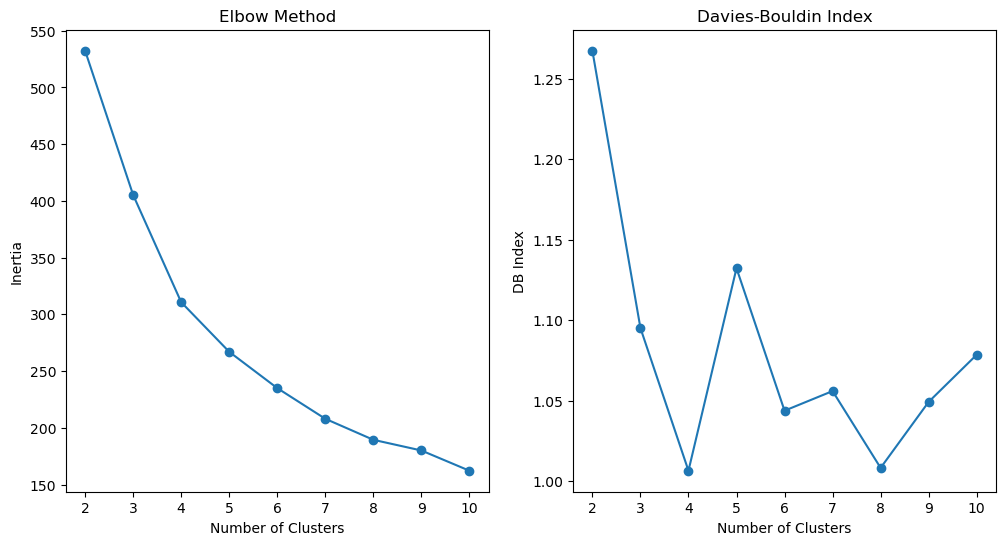

In [17]:
# Plotting the Elbow method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), db_indices, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# **Fit the K-Means Model:** Choose the optimal number of clusters based on the Elbow method and fit the model.

In [18]:
# Choose the optimal number of clusters (e.g., 4 based on the elbow method)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(features_scaled)

KMeans(n_clusters=4, random_state=42)

In [19]:
# Add cluster labels to the customer features DataFrame
customer_features['Cluster'] = kmeans.labels_

In [20]:
# Calculate clustering metrics
db_index = davies_bouldin_score(features_scaled, kmeans.labels_)
silhouette_avg = silhouette_score(features_scaled, kmeans.labels_)

In [21]:
print(f'Number of clusters formed: {optimal_clusters}')
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')

Number of clusters formed: 4
Davies-Bouldin Index: 1.0065021512838017
Silhouette Score: 0.319170794787564


# **Step 3: Visualization**
## **Visualize the Clusters:** Use PCA to reduce the dimensionality of the features for visualization.

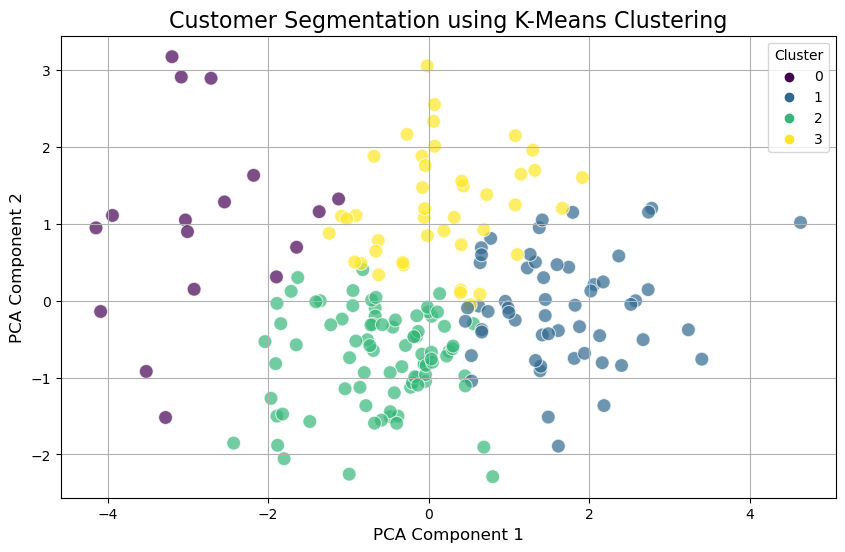

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot to visualize the clusters
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.7, edgecolor='w')

# Add titles and labels
plt.title('Customer Segmentation using K-Means Clustering', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

# Create a legend
plt.legend(title='Cluster', loc='best')

# Show the plot
plt.grid(True)
plt.show()

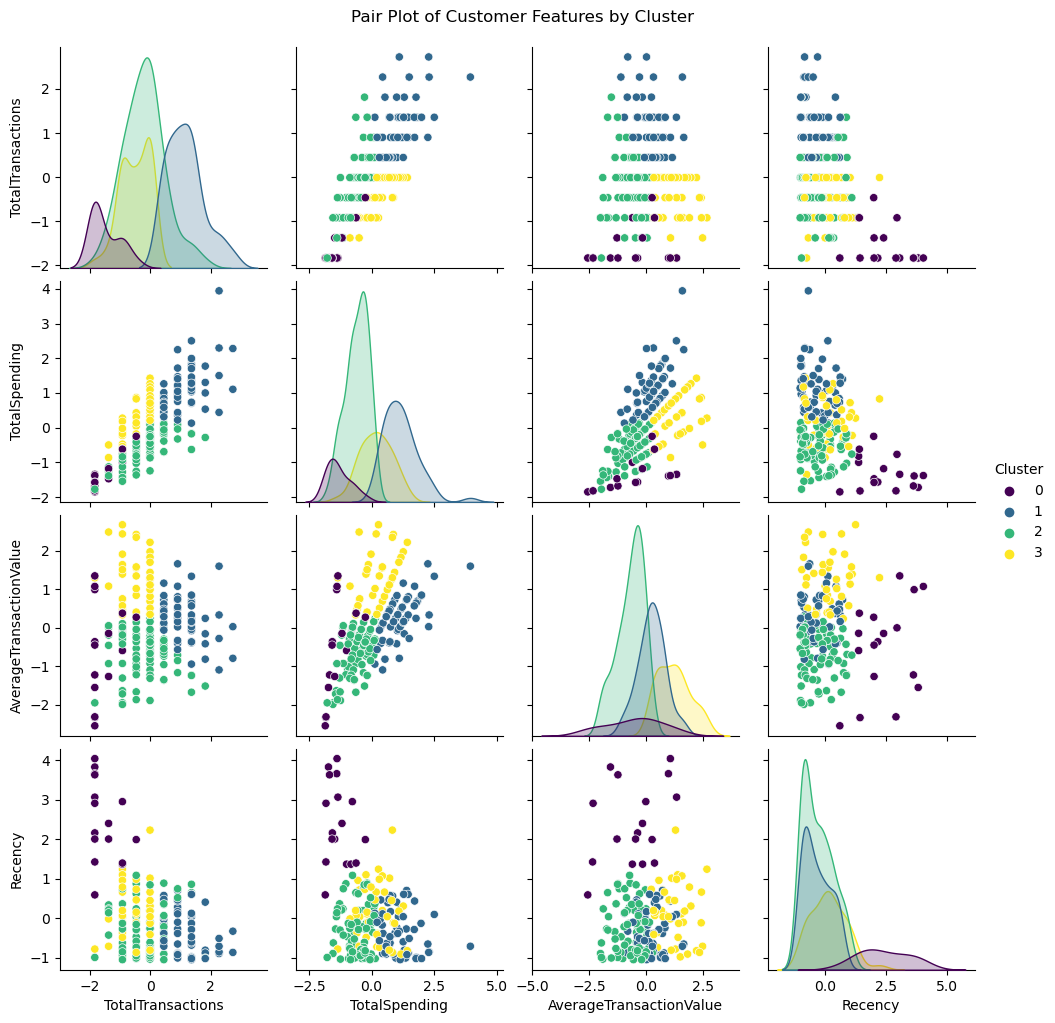

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add cluster labels to the original features DataFrame for pair plot
features_with_clusters = pd.DataFrame(features_scaled, columns=['TotalTransactions', 'TotalSpending', 'AverageTransactionValue', 'Recency'])
features_with_clusters['Cluster'] = customer_features['Cluster'].values

# Create a pair plot
sns.pairplot(features_with_clusters, hue='Cluster', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features by Cluster', y=1.02)
plt.show()

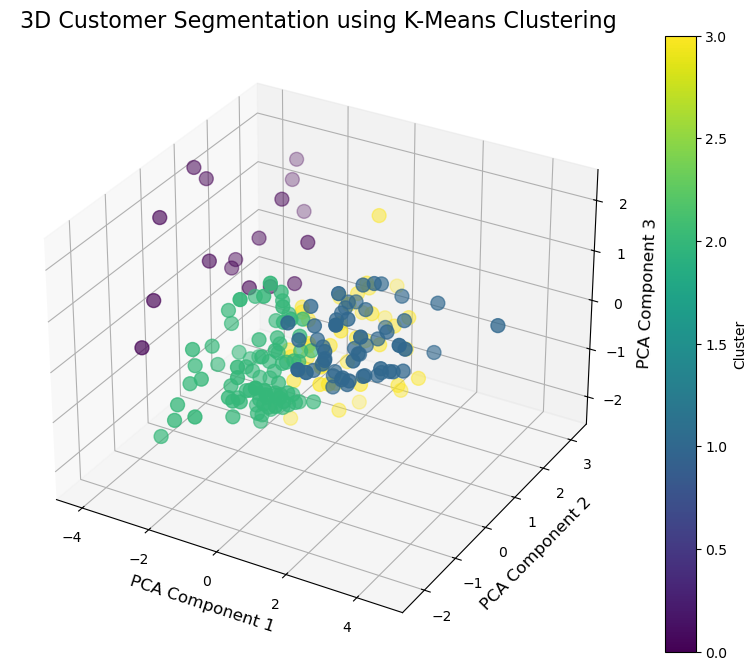

In [31]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA to reduce dimensions to 3
pca_3d = PCA(n_components=3)
features_pca_3d = pca_3d.fit_transform(features_scaled)

# Create a DataFrame for the PCA results
pca_3d_df = pd.DataFrame(data=features_pca_3d, columns=['PCA1', 'PCA2', 'PCA3'])
pca_3d_df['Cluster'] = customer_features['Cluster'].values  # Add cluster labels

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_3d_df['PCA1'], pca_3d_df['PCA2'], pca_3d_df['PCA3'], c=pca_3d_df['Cluster'], cmap='viridis', s=100)

# Add titles and labels
ax.set_title('3D Customer Segmentation using K-Means Clustering', fontsize=16)
ax.set_xlabel('PCA Component 1', fontsize=12)
ax.set_ylabel('PCA Component 2', fontsize=12)
ax.set_zlabel('PCA Component 3', fontsize=12)

# Create a legend
plt.colorbar(scatter, label='Cluster')
plt.show()